In [1]:
import os
import math
import timm
import glob
import torch
import random
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

In [2]:
# Load pretrained ViT
vit_encoder = timm.create_model('vit_base_patch16_224', pretrained=True)
vit_encoder.eval()  # set to eval if freezing weights


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [3]:
class SuperResolutionDataset(Dataset):
    def __init__(self, file_list, upscale_factor=4):
        self.file_list = file_list
        self.upscale_factor = upscale_factor
        
        self.hr_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        self.lr_transform = transforms.Compose([
            transforms.Resize((256 // upscale_factor, 256 // upscale_factor)),
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        image = Image.open(img_path).convert("RGB")
        hr = self.hr_transform(image)
        lr = self.lr_transform(image)
        return lr, hr


In [4]:
# Get all image paths from all subfolders
all_images = glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.jpg", recursive=True)
all_images += glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.png", recursive=True)
all_images += glob.glob("/Users/helenacooper/Desktop/9. semester/applied_deep_learning/images/**/*.jpeg", recursive=True)

# Split into train/test (e.g., 80% train, 20% test)
train_files, test_files = train_test_split(all_images, test_size=0.2, random_state=42)

train_dataset = SuperResolutionDataset(train_files)
test_dataset = SuperResolutionDataset(test_files)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [5]:
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)
    print(f"✅ Saved checkpoint: {filename}")

def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    if os.path.exists(filename):
        checkpoint = torch.load(filename, map_location="cpu")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"🔄 Loaded checkpoint from epoch {start_epoch}")
        return start_epoch
    else:
        print("⚠️ No checkpoint found.")
        return 0


In [6]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    PIXEL_MAX = 1.0  # assuming normalized to [0, 1]
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def calculate_ssim(img1, img2):
    # skimage expects H×W×C
    return ssim(img1, img2, data_range=1.0, channel_axis=2)


In [7]:
class DoubleConv(nn.Module):
    """(Conv2d -> ReLU) x2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class ViT_UNet(nn.Module):
    def __init__(self, vit_model_name='vit_base_patch16_224', pretrained=True, out_channels=3, img_size=224, patch_size=16):
        super(ViT_UNet, self).__init__()

        self.vit = timm.create_model(vit_model_name, pretrained=pretrained)
        self.img_size = img_size
        self.patch_size = patch_size

        # decoder layers
        self.up1 = nn.ConvTranspose2d(768, 256, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(256, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(64, 64)
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        B, C, H, W = x.shape
        # resize input to ViT expected size
        x_resized = F.interpolate(x, size=(self.img_size, self.img_size), mode='bilinear', align_corners=False)

        # forward through ViT
        #vit_features = self.vit.forward_features(x_resized)  # shape [B, num_patches, 768]


        vit_features = self.vit.forward_features(x_resized)  # [B, num_patches+1, 768]
        vit_features = vit_features[:, 1:, :]               # drop CLS token
        H_patch = W_patch = self.img_size // self.patch_size
        feat_map = vit_features.permute(0, 2, 1).reshape(B, 768, H_patch, W_patch)


        # reshape patch embeddings into 2D feature map
        H_patch = W_patch = self.img_size // self.patch_size
        feat_map = vit_features.permute(0, 2, 1).reshape(B, 768, H_patch, W_patch)

        # decoder
        x = self.up1(feat_map)
        x = self.conv1(x)
        x = self.up2(x)
        x = self.conv2(x)
        x = self.up3(x)
        x = self.conv3(x)
        out = self.final_conv(x)

        # resize back to original input size
        out = F.interpolate(out, size=(H, W), mode='bilinear', align_corners=False)
        return out


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_UNet(pretrained=True).to(device)

# optionally freeze ViT encoder for faster training
for param in model.vit.parameters():
    param.requires_grad = False

# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)


In [11]:
num_epochs = 75

Image.MAX_IMAGE_PIXELS = None

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_losses = []
    for low_res, high_res in tqdm(train_loader):
        low_res, high_res = low_res.to(device), high_res.to(device)

        optimizer.zero_grad()
        outputs = model(low_res)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        
    save_checkpoint(model, optimizer, epoch, running_loss/len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


100%|██████████| 69/69 [02:49<00:00,  2.46s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [1/75], Loss: 0.0123


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [2/75], Loss: 0.0117


100%|██████████| 69/69 [02:33<00:00,  2.22s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [3/75], Loss: 0.0113


100%|██████████| 69/69 [02:39<00:00,  2.32s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [4/75], Loss: 0.0109


100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [5/75], Loss: 0.0108


100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [6/75], Loss: 0.0103


100%|██████████| 69/69 [02:34<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [7/75], Loss: 0.0102


100%|██████████| 69/69 [02:36<00:00,  2.27s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [8/75], Loss: 0.0099


100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [9/75], Loss: 0.0096


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [10/75], Loss: 0.0098


100%|██████████| 69/69 [06:48<00:00,  5.92s/it]  


✅ Saved checkpoint: checkpoint.pth
Epoch [11/75], Loss: 0.0095


100%|██████████| 69/69 [02:33<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [12/75], Loss: 0.0094


100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [13/75], Loss: 0.0092


100%|██████████| 69/69 [02:34<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [14/75], Loss: 0.0092


100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [15/75], Loss: 0.0094


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [16/75], Loss: 0.0095


100%|██████████| 69/69 [03:24<00:00,  2.97s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [17/75], Loss: 0.0093


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [18/75], Loss: 0.0088


100%|██████████| 69/69 [02:33<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [19/75], Loss: 0.0086


100%|██████████| 69/69 [02:37<00:00,  2.29s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [20/75], Loss: 0.0083


100%|██████████| 69/69 [02:30<00:00,  2.19s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [21/75], Loss: 0.0083


100%|██████████| 69/69 [02:32<00:00,  2.20s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [22/75], Loss: 0.0083


100%|██████████| 69/69 [02:33<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [23/75], Loss: 0.0081


100%|██████████| 69/69 [02:33<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [24/75], Loss: 0.0080


100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [25/75], Loss: 0.0084


100%|██████████| 69/69 [02:36<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [26/75], Loss: 0.0085


100%|██████████| 69/69 [02:33<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [27/75], Loss: 0.0081


100%|██████████| 69/69 [02:30<00:00,  2.18s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [28/75], Loss: 0.0099


100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [29/75], Loss: 0.0088


100%|██████████| 69/69 [02:31<00:00,  2.20s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [30/75], Loss: 0.0070


100%|██████████| 69/69 [02:31<00:00,  2.19s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [31/75], Loss: 0.0064


100%|██████████| 69/69 [02:31<00:00,  2.19s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [32/75], Loss: 0.0057


100%|██████████| 69/69 [02:31<00:00,  2.20s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [33/75], Loss: 0.0055


100%|██████████| 69/69 [02:32<00:00,  2.20s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [34/75], Loss: 0.0057


100%|██████████| 69/69 [02:31<00:00,  2.19s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [35/75], Loss: 0.0053


100%|██████████| 69/69 [02:31<00:00,  2.19s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [36/75], Loss: 0.0050


100%|██████████| 69/69 [06:12<00:00,  5.40s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [37/75], Loss: 0.0048


100%|██████████| 69/69 [09:32<00:00,  8.29s/it]  


✅ Saved checkpoint: checkpoint.pth
Epoch [38/75], Loss: 0.0048


100%|██████████| 69/69 [02:52<00:00,  2.50s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [39/75], Loss: 0.0045


100%|██████████| 69/69 [02:33<00:00,  2.23s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [40/75], Loss: 0.0042


100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [41/75], Loss: 0.0041


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [42/75], Loss: 0.0040


100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [43/75], Loss: 0.0039


100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [44/75], Loss: 0.0038


100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [45/75], Loss: 0.0044


100%|██████████| 69/69 [02:36<00:00,  2.26s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [46/75], Loss: 0.0044


100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [47/75], Loss: 0.0040


100%|██████████| 69/69 [02:36<00:00,  2.27s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [48/75], Loss: 0.0036


100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [49/75], Loss: 0.0036


100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [50/75], Loss: 0.0036


100%|██████████| 69/69 [02:34<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [51/75], Loss: 0.0035


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [52/75], Loss: 0.0035


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [53/75], Loss: 0.0036


100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [54/75], Loss: 0.0036


100%|██████████| 69/69 [02:35<00:00,  2.26s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [55/75], Loss: 0.0036


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [56/75], Loss: 0.0037


100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [57/75], Loss: 0.0040


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [58/75], Loss: 0.0040


100%|██████████| 69/69 [02:36<00:00,  2.27s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [59/75], Loss: 0.0036


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [60/75], Loss: 0.0032


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [61/75], Loss: 0.0032


100%|██████████| 69/69 [02:39<00:00,  2.31s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [62/75], Loss: 0.0030


100%|██████████| 69/69 [02:38<00:00,  2.30s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [63/75], Loss: 0.0031


100%|██████████| 69/69 [02:35<00:00,  2.25s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [64/75], Loss: 0.0030


100%|██████████| 69/69 [02:36<00:00,  2.27s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [65/75], Loss: 0.0030


100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [66/75], Loss: 0.0031


100%|██████████| 69/69 [02:34<00:00,  2.24s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [67/75], Loss: 0.0030


100%|██████████| 69/69 [02:45<00:00,  2.40s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [68/75], Loss: 0.0029


100%|██████████| 69/69 [02:47<00:00,  2.42s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [69/75], Loss: 0.0029


100%|██████████| 69/69 [02:37<00:00,  2.29s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [70/75], Loss: 0.0030


100%|██████████| 69/69 [02:39<00:00,  2.31s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [71/75], Loss: 0.0030


100%|██████████| 69/69 [02:36<00:00,  2.27s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [72/75], Loss: 0.0034


100%|██████████| 69/69 [02:37<00:00,  2.28s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [73/75], Loss: 0.0032


100%|██████████| 69/69 [02:39<00:00,  2.30s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [74/75], Loss: 0.0031


100%|██████████| 69/69 [02:48<00:00,  2.45s/it]


✅ Saved checkpoint: checkpoint.pth
Epoch [75/75], Loss: 0.0035


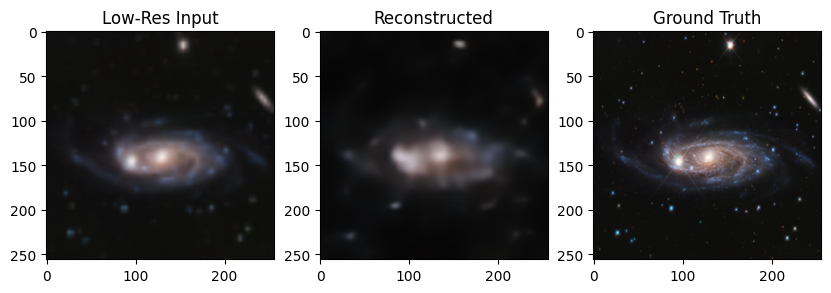

In [12]:
model.eval()
with torch.no_grad():
    sample_lr, sample_hr = next(iter(test_loader))
    sample_lr, sample_hr = sample_lr.to(device), sample_hr.to(device)
    pred = model(sample_lr)

# Convert tensor → image
plt.figure(figsize=(10,3))
plt.subplot(1,3,1)
plt.title("Low-Res Input")
plt.imshow(np.transpose(sample_lr[0].cpu().numpy(), (1,2,0)))
plt.subplot(1,3,2)
plt.title("Reconstructed")
plt.imshow(np.transpose(pred[0].cpu().numpy(), (1,2,0)))
plt.subplot(1,3,3)
plt.title("Ground Truth")
plt.imshow(np.transpose(sample_hr[0].cpu().numpy(), (1,2,0)))
plt.show()


In [13]:
model.eval()
psnr_scores = []
ssim_scores = []

with torch.no_grad():
    for lr, hr in test_loader:
        lr, hr = lr.to(device), hr.to(device)
        pred = model(lr)
        pred = pred.clamp(0, 1)

        # Convert to numpy for metric calculation
        pred_np = np.transpose(pred[0].cpu().numpy(), (1,2,0))
        hr_np = np.transpose(hr[0].cpu().numpy(), (1,2,0))

        psnr_scores.append(calculate_psnr(pred_np, hr_np))
        ssim_scores.append(calculate_ssim(pred_np, hr_np))

print(f"🔍 PSNR: {np.mean(psnr_scores):.2f}, SSIM: {np.mean(ssim_scores):.3f}")


🔍 PSNR: 21.97, SSIM: 0.699


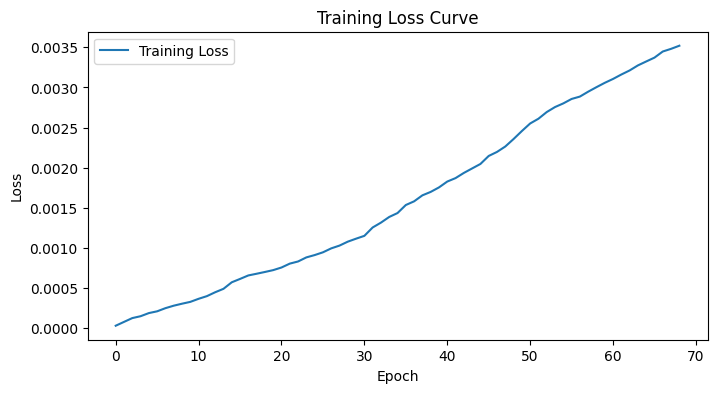

In [14]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()
